In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape, Activation, Dropout, Reshape, BatchNormalization

from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
img_rows=28
img_cols=28
channels=1
img_shape= (img_rows,img_cols,channels)
z_dim=100

In [3]:
def build_generator(z_dim):
    model=Sequential()
    model.add(Dense(256*7*7, input_dim=z_dim))# reshapes input into 7*7*256 tensor
    model.add(Reshape((7,7,256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
        # Transposed model from 7*7*256 to 14*14*128 tensor
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
        # Transposed model from 14*14*128 to 14*14*64 tensor
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
        # Transposed model from 14*14*64 into 28*28*1 tensor
    model.add(Activation('tanh'))
    return model

def build_discriminator(img_shape):
    model=Sequential()
    model.add(Conv2D(32, kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
        # 28*28*1 -> 14*14*32
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2D(64, kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
        # 14*14*32 -> 7*7*64
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
        
    model.add(Conv2D(128, kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
        # 7*7*64 -> 3*3*128
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    model=Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [4]:
discriminator= build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(), metrics=['accuracy'])
generator= build_generator(z_dim)
discriminator.trainable=False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [5]:
losses=[]
accuracies=[]
iteration_checkpoints=[]

def train(iterations, batch_size, sample_interval):
    (x_train, _), (_, _) = mnist.load_data()
    
    x_train = x_train/127.5 -1.0 # normalized pixels in range -1 to 1
    x_train = np.expand_dims(x_train, axis=3)
    real = np.ones((batch_size, 1))# label for real images
    fake = np.zeros((batch_size,1))# Label for fake images
    
    for iteration in range(iterations):
        idx=np.random.randint(0,x_train.shape[0], batch_size)# real images
        imgs=x_train[idx]
        
        z=np.random.normal(0,1, (batch_size, 100))# fake images
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)# True positive
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)# True negative
        d_loss, accuracy= 0.5* np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0,1, (batch_size, 100))# fake_images
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration+1) % sample_interval==0:
            losses.append((d_loss, g_loss)) # save lossed for plotting
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration+1)
            
                    
            print("%d [D lossL %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0*accuracy, g_loss))
            sample_images(generator)

In [6]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z=np.random.normal(0,1, (image_grid_rows * image_grid_columns,z_dim))
            # sample random noise
    gen_imgs= generator.predict(z)
    gen_imgs= 0.5 * gen_imgs+0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,figsize=(4,4),
                          sharey=True, sharex=True)
    cnt=0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap='gray')
            axs[i,j].axis('off')
            cnt+=1

10 [D lossL 0.021453, acc.: 100.00%] [G loss: 0.710897]
20 [D lossL 0.007768, acc.: 100.00%] [G loss: 0.813261]
30 [D lossL 0.006481, acc.: 100.00%] [G loss: 0.724442]
40 [D lossL 0.013299, acc.: 100.00%] [G loss: 0.918723]
50 [D lossL 0.002823, acc.: 100.00%] [G loss: 1.075423]
60 [D lossL 0.002903, acc.: 100.00%] [G loss: 1.046582]
70 [D lossL 0.002524, acc.: 100.00%] [G loss: 0.954893]
80 [D lossL 0.002163, acc.: 100.00%] [G loss: 0.752374]
90 [D lossL 0.001792, acc.: 100.00%] [G loss: 0.650490]
100 [D lossL 0.001069, acc.: 100.00%] [G loss: 0.768346]
110 [D lossL 0.001777, acc.: 100.00%] [G loss: 0.669342]
120 [D lossL 0.000883, acc.: 100.00%] [G loss: 0.564718]
130 [D lossL 0.000507, acc.: 100.00%] [G loss: 0.497159]
140 [D lossL 0.000536, acc.: 100.00%] [G loss: 0.351319]
150 [D lossL 0.000753, acc.: 100.00%] [G loss: 0.300520]
160 [D lossL 0.000517, acc.: 100.00%] [G loss: 0.334225]
170 [D lossL 0.000368, acc.: 100.00%] [G loss: 0.334390]
180 [D lossL 0.000285, acc.: 100.00%] [G

<ipython-input-6-d45225eea9be>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(image_grid_rows, image_grid_columns,figsize=(4,4),


220 [D lossL 0.000116, acc.: 100.00%] [G loss: 0.053513]
230 [D lossL 0.000192, acc.: 100.00%] [G loss: 0.053546]
240 [D lossL 0.000128, acc.: 100.00%] [G loss: 0.046205]
250 [D lossL 0.000129, acc.: 100.00%] [G loss: 0.036232]
260 [D lossL 0.000155, acc.: 100.00%] [G loss: 0.023241]
270 [D lossL 0.000128, acc.: 100.00%] [G loss: 0.019810]
280 [D lossL 0.000082, acc.: 100.00%] [G loss: 0.016995]
290 [D lossL 0.000069, acc.: 100.00%] [G loss: 0.013919]
300 [D lossL 0.000054, acc.: 100.00%] [G loss: 0.011302]
310 [D lossL 0.000054, acc.: 100.00%] [G loss: 0.010453]
320 [D lossL 0.000065, acc.: 100.00%] [G loss: 0.009966]
330 [D lossL 0.000036, acc.: 100.00%] [G loss: 0.009235]
340 [D lossL 0.000038, acc.: 100.00%] [G loss: 0.008813]
350 [D lossL 0.000030, acc.: 100.00%] [G loss: 0.009414]
360 [D lossL 0.000029, acc.: 100.00%] [G loss: 0.009791]
370 [D lossL 0.000031, acc.: 100.00%] [G loss: 0.009150]
380 [D lossL 0.000032, acc.: 100.00%] [G loss: 0.008078]
390 [D lossL 0.000035, acc.: 10

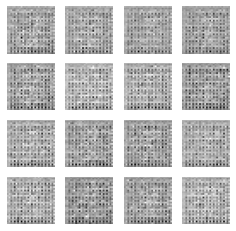

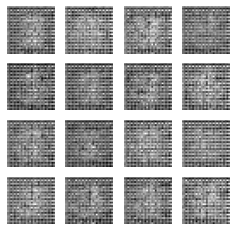

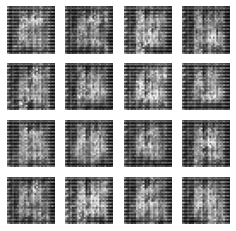

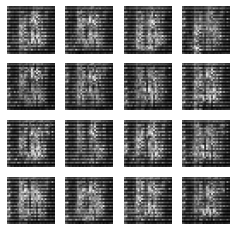

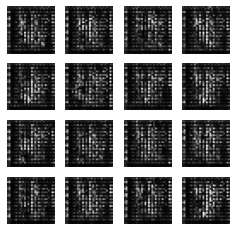

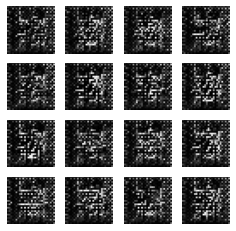

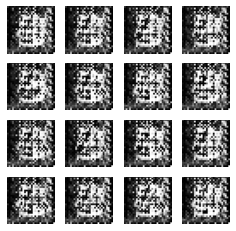

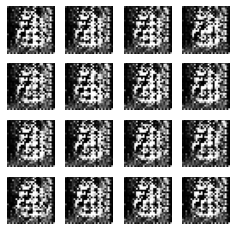

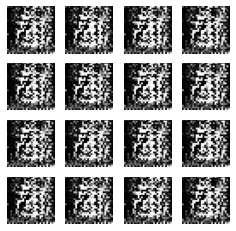

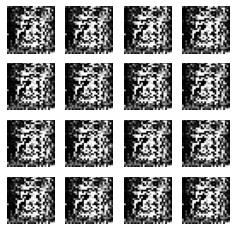

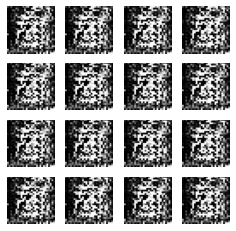

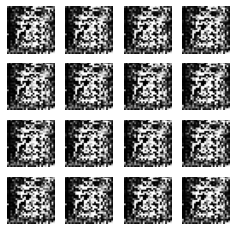

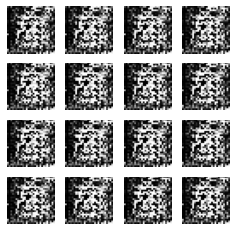

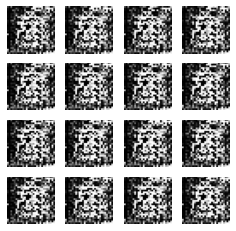

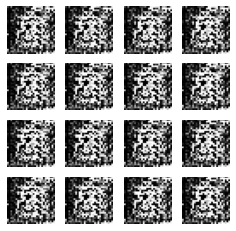

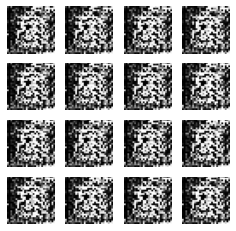

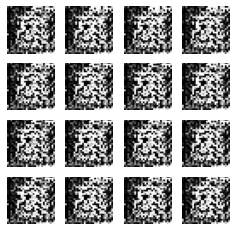

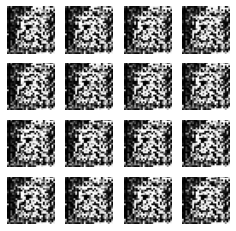

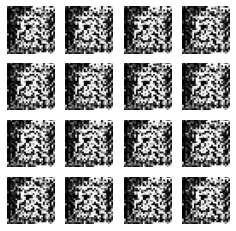

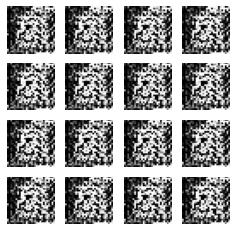

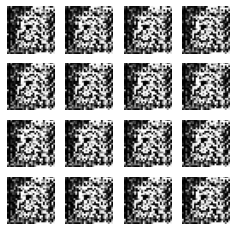

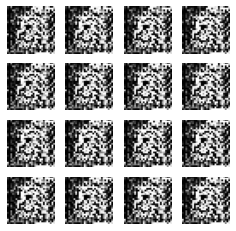

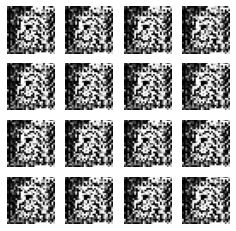

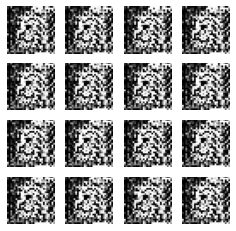

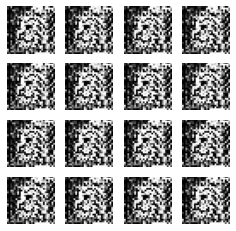

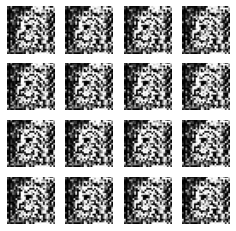

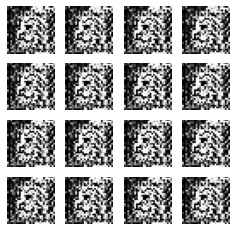

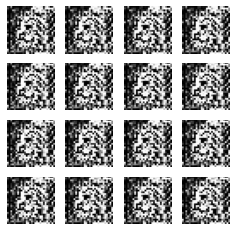

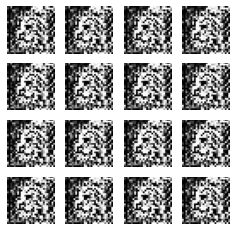

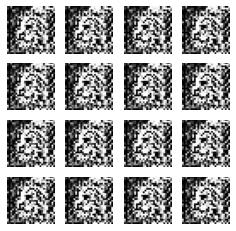

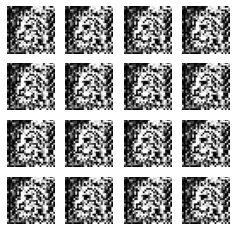

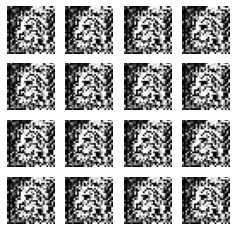

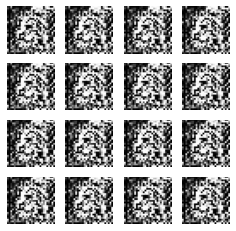

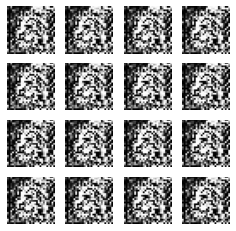

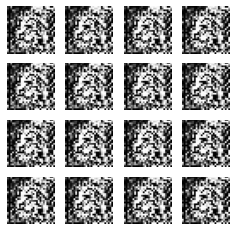

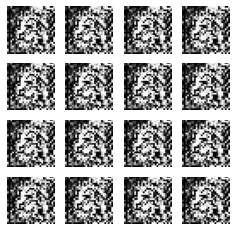

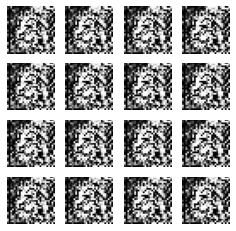

In [7]:
iterations=500
batch_size=128
sample_interval=10

train(iterations,batch_size, sample_interval)